# package和数据导入

## 包导入

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
layers = keras.layers
models = keras.models
optimizers = keras.optimizers
regularizers = keras.regularizers

# pandas设置
pd.options.display.max_columns = 10
pd.options.display.max_rows = 10

Using Theano backend.


## 数据导入

In [2]:
eload = pd.read_excel("LoadData.xlsx", parse_dates=True, index_col='YMD').asfreq('D')
# eload.set_axis(range(0,24*60, 15),axis=1, inplace=True)
eload.set_axis(np.linspace(0, 24, 96, endpoint=False),axis=1, inplace=True)
eload.dropna(inplace=True)
eload.head()

,0.0,0.25,0.5,0.75,1.0,...,22.75,23.0,23.25,23.5,23.75
YMD,,,,,,,,,,,
2009-01-01,3210.842464,3104.507008,3037.705984,2960.176288,2889.226528,...,2734.114816,2610.683872,2485.757536,2382.696928,2276.210080
2009-01-02,2163.988288,2074.737568,1999.624960,1950.288448,1889.142112,...,3964.573792,3774.516256,3587.174176,3424.568608,3266.948608
2009-01-03,3109.127008,3015.901120,2938.305664,2869.375744,2815.772224,...,4127.941984,3955.490752,3774.541120,3602.281312,3444.148000
2009-01-04,3307.752544,3209.726368,3125.514016,3075.184864,3028.708768,...,4124.856256,3940.387648,3767.990560,3602.398720,3477.076768
2009-01-05,3295.415776,3278.379328,3232.313632,3160.731232,3124.226368,...,4710.734656,4471.342144,4295.259520,4106.356096,3933.511360


In [3]:
weather = pd.read_excel("LoadData.xlsx", sheet_name='Area1_Weather',
                        parse_dates=True, index_col='YMD').asfreq('D')
weather.dropna(inplace=True)
weather.head()

,最高温度℃,最低温度℃,平均温度℃,相对湿度(平均),降雨量（mm）
YMD,,,,,
2012-01-01,19.5,12.1,15.8,63.0,0.0
2012-01-02,20.0,13.0,16.0,59.0,0.0
2012-01-03,18.7,14.2,15.8,72.0,0.0
2012-01-04,14.9,9.3,10.9,62.0,0.0
2012-01-05,9.2,5.1,6.9,78.0,2.9


## 可视化：负荷长期趋势

In [6]:
plt.style.use('seaborn')

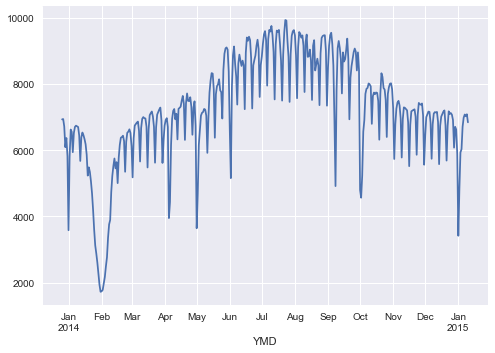

In [7]:
eload.mean(axis=1)[356*5+40:].plot(label='mean')
# eload.max(axis=1).plot(label='max')
# eload.min(axis=1).plot(label='min')
# plt.legend()
# plt.savefig('images/yearload.svg')
plt.show()

## 爬虫：节假日数据获取

In [ ]:
# import requests as req
# import json

# is_weekend = {6:1,0:0,1:0,2:0,3:0,4:0,5:1}
# weekend = [is_weekend[day] for day in weather.index.dayofweek]

# is_holiday = pd.Series(data=weekend,index=weather.index,name='休息日')
# for year in range(2012,2016):
#     for month in range(1,13):
#         api = "https://sp0.baidu.com/8aQDcjqpAAV3otqbppnN2DJv/api.php?query=%(y)s年%(m)s月&co=&resource_id=6018&t=1553089635252&ie=utf8&oe=gbk&cb=op_aladdin_callback&format=json&tn=baidu&cb=jQuery110207156589442772855_1553083393448&_=1553083393521"%\
#         {'y':year,'m':month}
#         res = req.get(api)
#         holiday = json.loads(res.text[46:-2])['data'][0]['holiday']
#         if isinstance(holiday,dict):
#             holiday = [holiday,]
#         for i in range(len(holiday)):
#             holidaylist = holiday[i]['list']
#             for obj in holidaylist:
#                 is_holiday[obj['date']] = 2-int(obj['status'])

In [8]:
xxr = pd.read_csv('xxr.csv',index_col='YMD',parse_dates=True).asfreq('D')
xxr

,休息日
YMD,
2012-01-01,1.0
2012-01-02,1.0
2012-01-03,1.0
2012-01-04,0.0
2012-01-05,0.0
...,...
2015-01-13,0.0
2015-01-14,0.0
2015-01-15,0.0


## 丢失数据处理

In [9]:
# 取交集
regweather = weather.dropna()
regload = eload.reindex(regweather.index).dropna()
regweather = regweather.reindex(regload.index).dropna()

# 数据预处理

## min-max 标准化

### 负荷数据标准化

In [10]:
load_min = regload.T.min()
load_max = regload.T.max()
load = ((regload.T - load_min) / (load_max - load_min)).T

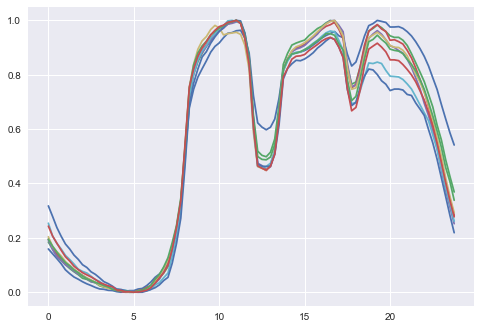

In [11]:
load[1:10].T.plot();plt.legend('');
# plt.savefig('images/dayload.svg');
plt.show()

In [12]:
# Data split
train_tar = load[:900]
val_tar = load[900:1097]
test_tar = load[1097:]

### 天气数据标准化

In [ ]:
train_data = regweather[:900]
val_data = regweather[900:1097]
test_data = regweather[1097:]

In [ ]:
weather_min = train_data.min()
weather_max = train_data.max()

train_data,val_data,test_data = [((data - weather_min) / (weather_max - weather_min)) \
                                 for data in (train_data,val_data,test_data)]

## z-score 标准化

### 负荷数据标准化

In [ ]:
load_mean = regload.mean(axis=1)
load_std = regload.std(axis=1)
load = regload.sub(load_mean, axis=0).div(load_std, axis=0)
load

### 天气数据标准化

In [101]:
train_data = regweather[:900]
val_data = regweather[900:1097]
test_data = regweather[1097:]

In [102]:
def normalize(data, mean, std):
    return data.sub(mean, axis=1).div(std, axis=1)

data_mean, data_std = train_data.mean(axis=0), train_data.std(axis=0)
train_data, val_data, test_data = \
(normalize(data, data_mean, data_std) for data in [train_data, val_data, test_data])

## 主成分分析（PCA）-- 去相关和数据降维

In [15]:
from sklearn.decomposition import PCA

In [103]:
pca = PCA(n_components=None)
pca.fit(train_data)
train_data_pca, val_data_pca, test_data_pca = (pca.transform(data) for data in \
                                              (train_data,val_data,test_data))

In [104]:
print('成分贡献率:',pca.explained_variance_ratio_,'\n总和：',pca.explained_variance_ratio_.sum())

成分贡献率: [0.59833039 0.26085424 0.12378815 0.01584227 0.00118494] 
总和： 0.9999999999999999


In [105]:
train_data_pca = pd.DataFrame(train_data_pca,index=train_data.index).join(xxr)
val_data_pca = pd.DataFrame(val_data_pca,index=val_data.index).join(xxr)
test_data_pca = pd.DataFrame(test_data_pca,index=test_data.index).join(xxr)

In [106]:
train_data,val_data,test_data = [data.join(xxr) for data in [train_data,val_data,test_data]]

# 构建模型

## no pca

In [20]:
# smooth function
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [56]:
def build_model(data, r=regularizers.l2(0.001)):
    model = models.Sequential()
    model.add(layers.Dense(4,input_dim = data.shape[1], activation='relu',))
    # model.add(layers.Dropout(0.3))
    model.add(layers.Dense(2, activation = 'relu',kernel_regularizer=r, ),)
    # model.add(layers.Dropout(0.3))
    model.add(layers.Dense(96))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [107]:
model = build_model(train_data,None)

In [23]:
def fit_model(model,train_data,val_data):
    EPOCHS = 1000  # 训练批次设置
    his = model.fit(train_data, train_tar, epochs=EPOCHS, batch_size=7,
                    validation_data=(val_data, val_tar), verbose=False)
    return his

In [108]:
his = fit_model(model,train_data,val_data)

In [126]:
def plots(his,item,t0=40,fn=None):
    if item == 'loss':
        plt.plot(his.epoch[t0:], his.history['loss'][t0:], label = 'train loss')
        plt.plot(his.epoch[t0:], smooth_curve(his.history['val_loss'])[t0:],'--', label = 'validation loss', )
        plt.ylabel('Loss')
    elif item == 'mae':
        train_mae = his.history['mean_absolute_error'];val_mae = his.history['val_mean_absolute_error']
        plt.plot(his.epoch[t0:], train_mae[t0:], label = 'train mae')
        plt.plot(his.epoch[t0:], smooth_curve(val_mae)[t0:],'--', label = 'validation mae', )
        plt.ylabel('MAE')
    else:print('no item');return None
    plt.legend(fontsize='x-large');
    plt.xlabel('EPOCHS');
    if fn:plt.savefig('images/'+fn+'.svg')
    plt.show()

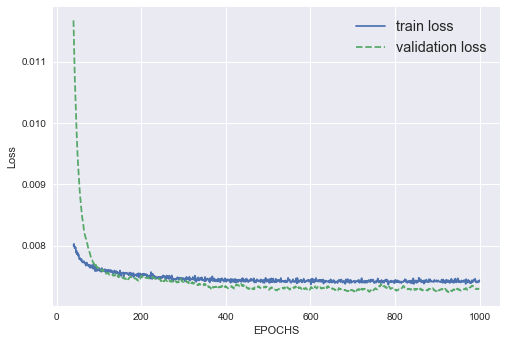

In [128]:
plots(his,'loss',fn='LC_nopca')

In [110]:
# loss and metric
model.evaluate(test_data,test_tar)

7/7 [==============================] - 0s 0us/step


[0.001422604196704924, 0.03051820769906044]

## pca model

In [111]:
model_pca = build_model(train_data_pca,None)

In [112]:
his_pca = fit_model(model_pca,train_data_pca,val_data_pca)

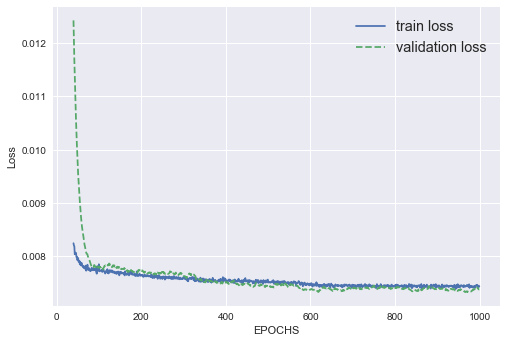

In [129]:
plots(his_pca,'loss',fn='LC_pca')

In [114]:
model_pca.evaluate(test_data_pca,test_tar)

7/7 [==============================] - 0s 428us/step


[0.0015450080391019583, 0.03223841264843941]

# 预测

In [115]:
# for min-max
real = test_tar.mul((load_max - load_min)[test_tar.index], axis=0).add(load_min[test_tar.index],axis=0)
predicted = pd.DataFrame(model.predict(test_data), index=test_tar.index,columns=test_tar.columns)
predicted = predicted.mul(load_max - load_min, axis=0).dropna().add(load_min,axis=0).dropna()

predicted_pca = pd.DataFrame(model_pca.predict(test_data_pca), index=test_tar.index,columns=test_tar.columns)
predicted_pca = predicted_pca.mul(load_max - load_min, axis=0).dropna().add(load_min,axis=0).dropna()

In [ ]:
# # for z-score
# real = test_tar.mul(std, axis=0).add(mean,axis=0).dropna()
# predicted = pd.DataFrame(model.predict(test_data),index=test_tar.index,columns=test_tar.columns)
# predicted = predicted.mul(std, axis=0).add(mean,axis=0).dropna()

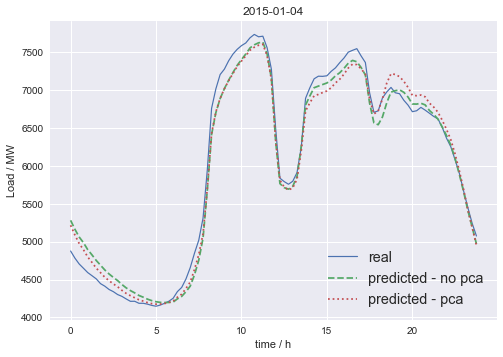

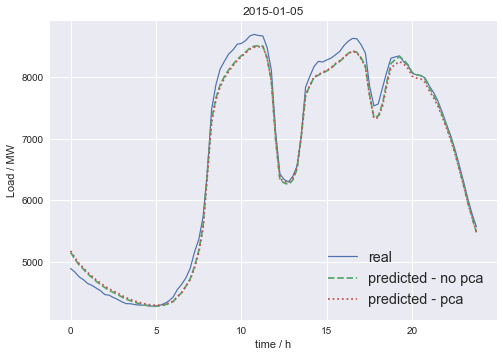

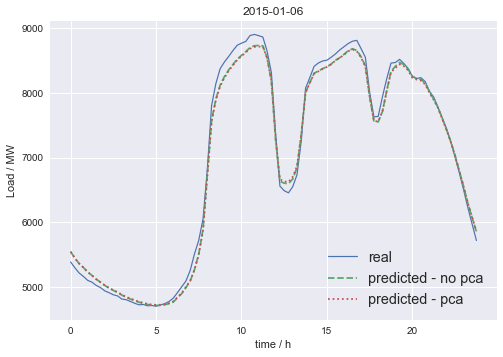

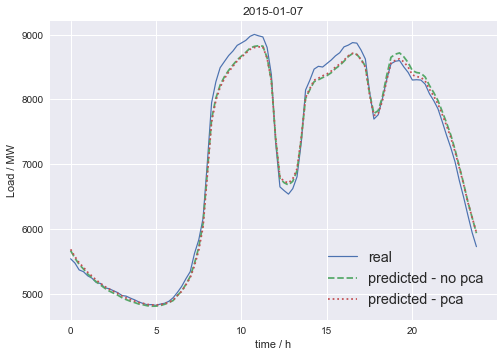

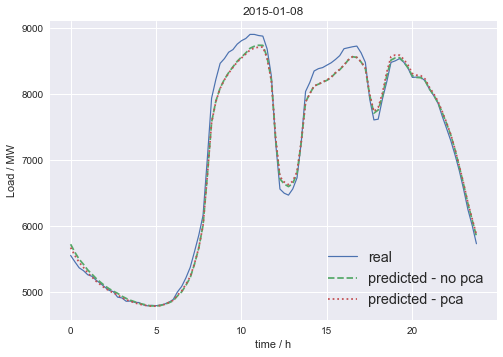

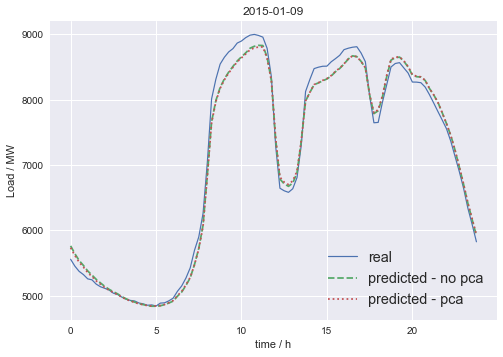

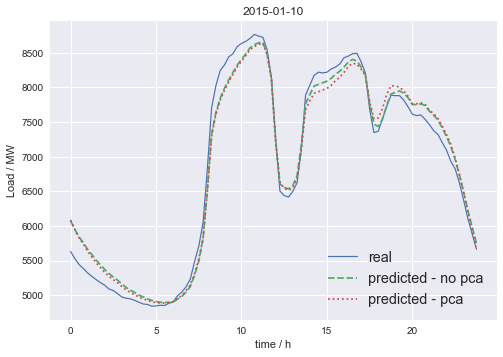

In [125]:
# 预测曲线和实际曲线对比
for idx in test_data.index:
    real.loc[idx].plot(label='real',lw=1.2)
    predicted.loc[idx].plot(label='predicted - no pca',linestyle='--')
    predicted_pca.loc[idx].plot(label='predicted - pca',linestyle='dotted')
    plt.legend(fontsize='x-large',loc='best')
    plt.title(str(idx)[:10])
    plt.xlabel('time / h');plt.ylabel('Load / MW')
#     plt.savefig('images/'+str(idx)[:10]+'load_pca.svg')
    plt.show()

In [ ]:
# 误差曲线
(predicted_pca-real).T.plot();plt.legend('');plt.show()

# 误差的统计建模

In [117]:
real_val = val_tar.mul((load_max - load_min)[val_tar.index], axis=0).add(load_min[val_tar.index],axis=0)
predicted_val = pd.DataFrame(model.predict(val_data), index=val_tar.index,columns=val_tar.columns)
predicted_val = predicted_val.mul(load_max - load_min, axis=0).dropna().add(load_min,axis=0).dropna()

In [118]:
err=predicted_val-real_val
err.apply([min,max,np.mean,np.std])

,0.0,0.25,0.5,0.75,1.0,...,22.75,23.0,23.25,23.5,23.75
min,-2048.573813,-1998.658245,-1954.822342,-1897.942024,-1804.486474,...,-1267.684086,-1378.158282,-1528.364115,-1664.209399,-1775.559536
max,957.153626,877.035675,824.818963,770.783436,728.441075,...,1245.973228,1174.806822,1106.364039,1112.439997,1073.099561
mean,90.564487,78.191121,71.320349,62.273167,55.474031,...,114.667339,90.257599,70.237440,45.231584,15.300812
std,365.016381,346.716745,331.296004,317.424551,298.989070,...,360.307608,371.802938,384.862169,402.653315,412.610402


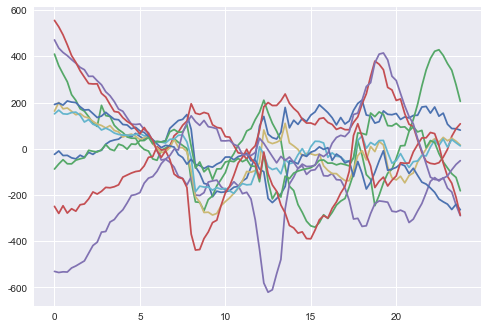

In [119]:
# 验证集误差曲线
err[:10].T.plot();plt.legend('');plt.show()

In [120]:
from scipy import stats
interval90 = stats.t.interval(0.90,err.shape[0],err.mean(axis=0),err.std(axis=0)/err.shape[0]**0.5)
interval95 = stats.t.interval(0.95,err.shape[0],err.mean(axis=0),err.std(axis=0)/err.shape[0]**0.5)

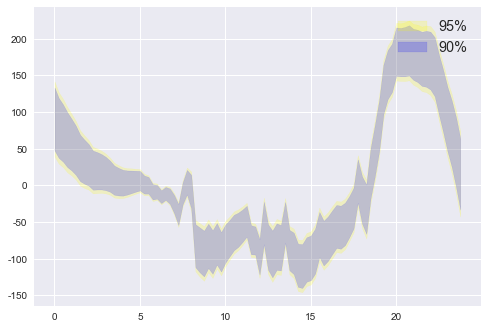

In [121]:
plt.fill_between(test_tar.columns,interval95[0],interval95[1],color='yellow',alpha=.2, label ='95%')
plt.fill_between(test_tar.columns,interval90[0],interval90[1],color='blue',alpha=.2, label ='90%')
plt.legend(fontsize='x-large')
# plt.title('95% confidence interval of error')
plt.show()
# 预测区间

## 预测值修正

In [75]:
# real_test = test_tar.mul((load_max - load_min)[test_tar.index], axis=0).add(load_min[test_tar.index],axis=0)
# predicted_test = pd.DataFrame(model.predict(test_data), index=test_tar.index,columns=test_tar.columns)
# predicted_test = predicted_test.mul(load_max - load_min, axis=0).dropna().add(load_min,axis=0).dropna()

In [122]:
top= predicted.sub(interval95[0],axis=1)
bottum= predicted.sub(interval95[1],axis=1)

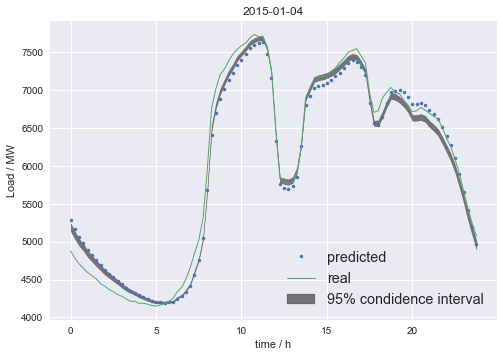

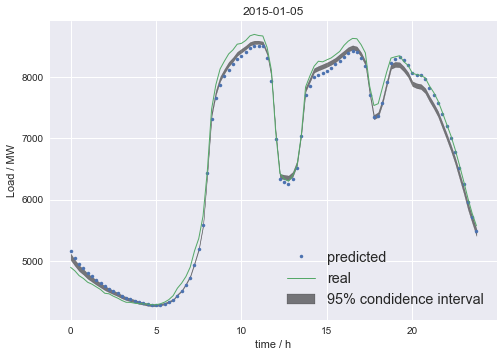

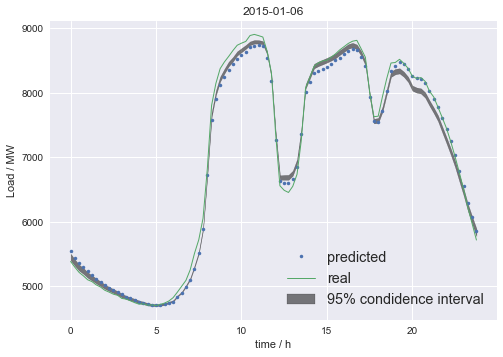

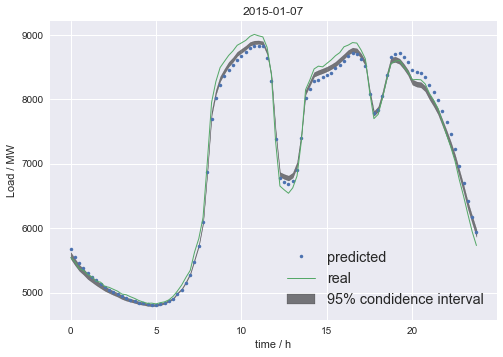

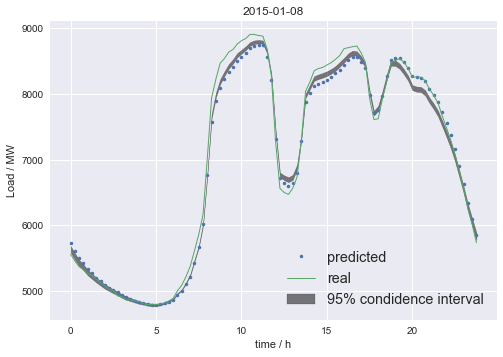

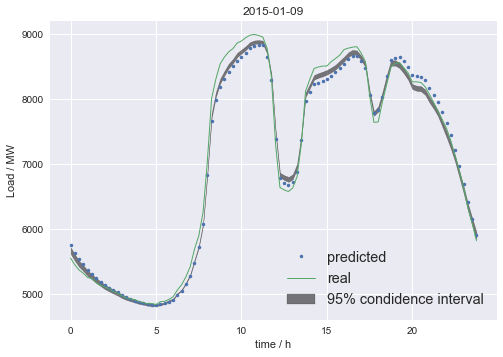

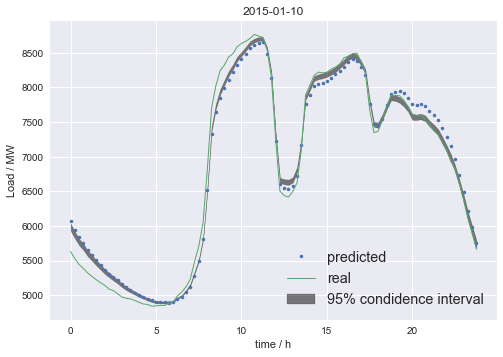

In [124]:
# 预测曲线和实际曲线对比
for i in range(len(test_data.index)):
    predicted.iloc[i].plot(lw=0, marker='.', label='predicted')
    real.iloc[i].plot(lw=1, label='real')
    plt.fill_between(test_tar.columns,bottum.iloc[i],top.iloc[i],
                    color='black',alpha=.5, label='95% condidence interval')
    plt.title(str(test_tar.index[i])[:10])
    plt.legend(fontsize='x-large',loc='best')
    plt.xlabel('time / h');plt.ylabel('Load / MW')
#     plt.savefig('images/'+str(test_tar.index[i])[:10]+'load_range.svg')
    plt.show()

In [132]:
test_data

,最高温度℃,最低温度℃,平均温度℃,相对湿度(平均),降雨量（mm）,休息日
YMD,,,,,,
2015-01-04,-0.490302,-1.282408,-0.973744,-0.347632,-0.346656,1.0
2015-01-05,-0.321226,-0.434043,-0.415432,0.156414,-0.346656,0.0
2015-01-06,-0.106039,-0.107750,-0.152697,0.300428,-0.346656,0.0
2015-01-07,-0.597895,-0.792967,-0.973744,-0.059605,-0.346656,0.0
2015-01-08,-1.243456,-1.510813,-1.367847,-1.499738,-0.346656,0.0
2015-01-09,-1.320309,-1.363981,-1.351426,-1.571745,-0.346656,0.0
2015-01-10,-0.936046,-1.217149,-1.121532,-1.499738,-0.346656,1.0


In [130]:
# 保存原始数据和结果数据
f = pd.ExcelWriter('data.xlsx')
regweather.to_excel(f,'天气数据')
xxr.to_excel(f,'节假日数据')
regload.to_excel(f,'负荷原始数据')
top.to_excel(f,'概率模型-上界')
bottum.to_excel(f,'概率模型-下界')
predicted.to_excel(f,'神经网络模型预测值 - 不使用PCA')
predicted_pca.to_excel(f,'神经网络模型预测值 - 使用PCA')
f.save();f.close()

## refine

In [ ]:
model2 = models.Sequential()
model2.add(layers.Dense(7,input_dim = len(train_data.columns),
                        activation='relu', kernel_regularizer=regularizers.l2(0.001),))
# model2.add(layers.Dropout(0.5))
# model2.add(layers.Dense(2, activation = 'relu',kernel_regularizer=regularizers.l2(0.001), ))
# model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(96))

model2.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [ ]:
EPOCHS = 500
his2 = model2.fit(train_data, train_tar, epochs=EPOCHS, batch_size=7,
                  validation_data=(val_data, val_tar), verbose=False)

train_loss = his2.history['loss']
val_loss = his2.history['val_loss']
train_mae = his2.history['mean_absolute_error']
val_mae = his2.history['val_mean_absolute_error']

In [ ]:
t0=40
plt.plot(his2.epoch[t0:], train_loss[t0:], '.', label = 'train_mse')
plt.plot(his2.epoch[t0:], smooth_curve(val_loss)[t0:], label = 'val_mse', )
plt.legend();plt.xlabel('EPOCHS');plt.ylabel('loss')
plt.show()

In [ ]:
plt.plot(his2.epoch[t0:], train_mae[t0:], '.', label = 'train_mae')
plt.plot(his2.epoch[t0:], smooth_curve(val_mae)[t0:], label = 'val_mae', )
plt.legend();plt.xlabel('EPOCHS');plt.ylabel('MAE')
plt.show()

In [ ]:
model2.evaluate(test_data,test_tar)

In [ ]:
a = test_tar.mul(load_max - load_min, axis=0).dropna().add(load_min,axis=0).dropna()
b = pd.DataFrame(model2.predict(test_data), index=test_tar.index,columns=test_tar.columns)
b = b.mul(load_max - load_min, axis=0).dropna().add(load_min,axis=0).dropna()

In [ ]:
def visual(real, predicted, std):
    if len(real) == len(predicted):
        num = len(real)
    else:
        print('length not aligned')
        return
    for i in range(num):
        plt.fill_between(predicted.columns,predicted.iloc[i]-std,predicted.iloc[i]+std,
                         alpha=.2,label='1Std range',color='black')
        plt.fill_between(predicted.columns,predicted.iloc[i]-2*std,predicted.iloc[i]+2*std,
                         alpha=.2,label='2Std range',color='black')
        plt.plot(real.iloc[i],label='real')
        plt.plot(predicted.iloc[i],'.',label='predicted',color='black',alpha=.4)
        plt.xlabel('Time / h');plt.ylabel('Load / MW')
        plt.gca().patch.set_facecolor('white')
        plt.grid(color='gray')
        plt.legend();plt.show()

visual(a,b,pre_std)

(b-a).T.plot();plt.legend('');plt.show()